In [1]:
import pandas as pd 
import numpy as np
import nltk
import re 
import os 
import random 
import matplotlib.pyplot as plt
import seaborn as sns 
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
clean_data = pd.read_csv('data/Corona_NLP_train.csv')

In [3]:
clean_data.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [4]:
from gensim.models import Word2Vec
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()

comms = clean_data['OriginalTweet']

eng_stopwords = stopwords.words('english')

def preprocess_text(text: str) -> str:
    text = text.lower()
    is_allowed_char = lambda c: c.isalpha() or c == ' '
    text = ''.join(list(filter(is_allowed_char, text)))
    
    is_stopword = lambda word: word not in eng_stopwords
    text = ' '.join(list(filter(is_stopword, text.split())))
    
    text = ' '.join(list(map(stemmer.stem, text.split())))
    return text

for ind in tqdm(range(0, len(comms)), total=len(comms)):
    comms[ind] = preprocess_text(comms[ind])

sentences = [comm.split() for comm in comms]
model = Word2Vec(sentences=sentences,
                 sg=False,  # cbow model
                 vector_size=100,
                 window=5,
                 seed=42,
                 epochs=15, 
                 min_count=1
                 )

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kules\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
  0%|                                                                                        | 0/41157 [00:00<?, ?it/s]<ipython-input-4-e56cf21fdac6>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comms[ind] = preprocess_text(comms[ind])
100%|███████████████████████████████████████████████████████████████████████████| 41157/41157 [01:39<00:00, 411.93it/s]


In [5]:
import umap

points = umap.UMAP(random_state=42).fit_transform(model.wv.vectors[:500])

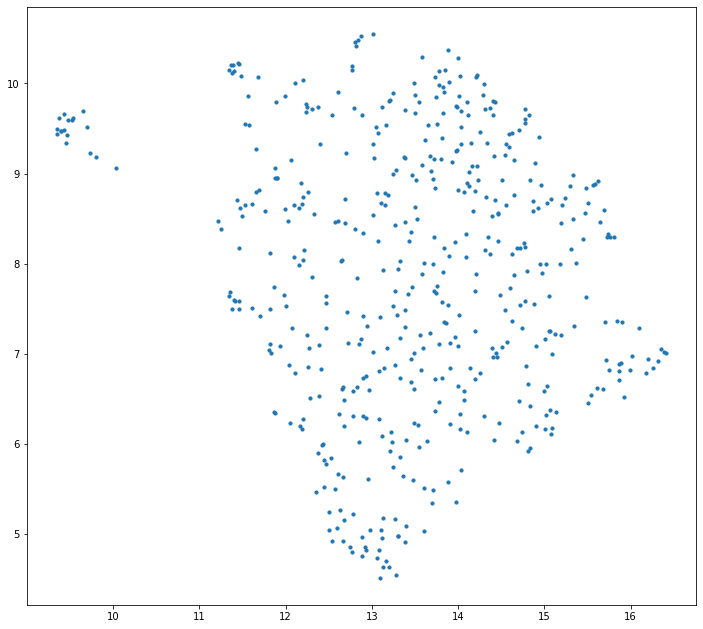

In [6]:
plt.figure(figsize=(12, 11))
plt.scatter(x=points[:, 0], y=points[:, 1], s=10)

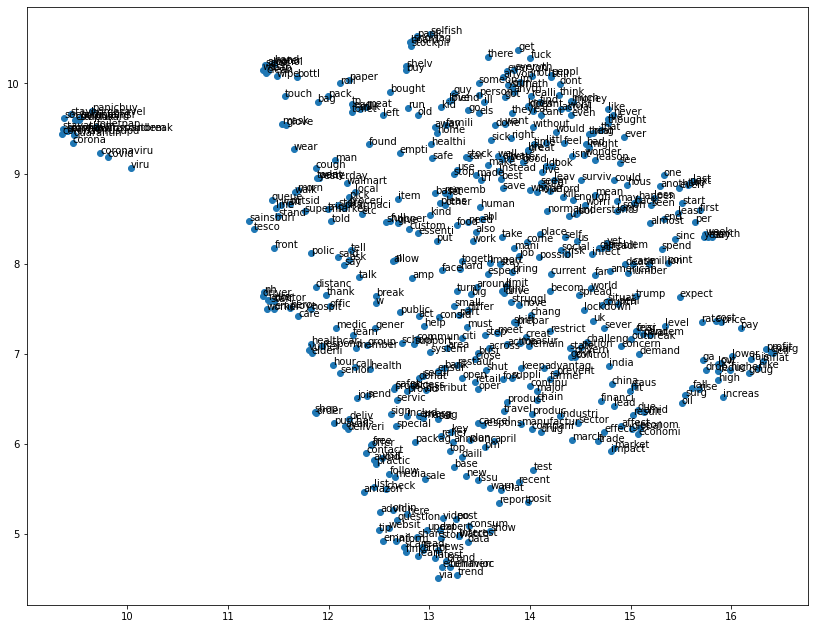

In [7]:
fig, ax = plt.subplots(figsize=(14, 11))
ax.scatter(points[:, 0], points[:, 1])

for i, txt in enumerate(model.wv.index_to_key[:500]):
    ax.annotate(txt, (points[i, 0], points[i, 1]))

In [8]:
model.wv.most_similar('virus')

[('bacteria', 0.9043872356414795),
 ('germ', 0.8660463094711304),
 ('coronavirusget', 0.8026050925254822),
 ('unb', 0.7918038368225098),
 ('airborn', 0.7646416425704956),
 ('skin', 0.7599050402641296),
 ('alcoholwip', 0.7440463900566101),
 ('massacr', 0.7409133315086365),
 ('httpstcolwrrmx', 0.7405498027801514),
 ('bacteri', 0.7404079437255859)]

In [9]:
model.wv.most_similar(negative=['virus'])

[('whitechapel', 0.4959185719490051),
 ('coronacrisiscovidpandem', 0.49418267607688904),
 ('crapper', 0.45632317662239075),
 ('worldvisionusa', 0.4506515860557556),
 ('eyerol', 0.45020270347595215),
 ('httpstconjukgqgq', 0.4450472593307495),
 ('leedsbas', 0.4230455458164215),
 ('hadleigh', 0.4206513464450836),
 ('httpstcorufpqkmb', 0.4064261317253113),
 ('ratear', 0.40425553917884827)]

In [10]:
virus_kill_peolple =model.wv.get_vector("virus") + model.wv.get_vector("kill") + model.wv.get_vector("peopl")

model.wv.similar_by_vector(virus_kill_peolple)

[('kill', 0.7894300222396851),
 ('peopl', 0.7655278444290161),
 ('infect', 0.7237532734870911),
 ('ppl', 0.6868378520011902),
 ('trap', 0.6826504468917847),
 ('possibl', 0.6781297326087952),
 ('contamin', 0.669732391834259),
 ('human', 0.6692197322845459),
 ('wont', 0.6687299013137817),
 ('doesnt', 0.6582146286964417)]

In [11]:
virus_kill_peolple =model.wv.get_vector("virus") + model.wv.get_vector("kill") + model.wv.get_vector("peopl")

model.wv.similar_by_vector(-virus_kill_peolple)

[('httpstcogmdeyfb', 0.4483985900878906),
 ('httpstcozctehurxa', 0.43994128704071045),
 ('coronacrisiscovidpandem', 0.4340868890285492),
 ('httpstcomqurhlin', 0.430358350276947),
 ('httpstcoorbczkjr', 0.4220164716243744),
 ('outro', 0.4191052317619324),
 ('httpstcobzipzsq', 0.4060724377632141),
 ('coronavirushttpstcowhcrvmhxo', 0.40540170669555664),
 ('httpstcovvyzbcori', 0.4047134518623352),
 ('dumont', 0.40236011147499084)]

In [12]:
stop_corona = model.wv.get_vector("stop") - model.wv.get_vector("corona")

model.wv.similar_by_vector(stop_corona)

[('stop', 0.6773975491523743),
 ('afridiminahil', 0.4992865324020386),
 ('allow', 0.48815110325813293),
 ('httpstcofdchiaevd', 0.4826248288154602),
 ('beleagu', 0.48068782687187195),
 ('limit', 0.4804256558418274),
 ('also', 0.47768664360046387),
 ('sectorsotherwis', 0.4706135094165802),
 ('fair', 0.4681110680103302),
 ('encourag', 0.4659450650215149)]

In [13]:
model.wv.similar_by_vector(-stop_corona)

[('httpstcovwazwdviah', 0.6973385214805603),
 ('corona', 0.6780430674552917),
 ('smehttpstcoapxwtyrip', 0.6661126017570496),
 ('canyoupopoutandpickupaf', 0.6570208668708801),
 ('washingtonheight', 0.6447041630744934),
 ('httpstcozdahstd', 0.6276150941848755),
 ('httpstcohfmdqdfx', 0.6270076632499695),
 ('httpstcoescplnawaa', 0.6245463490486145),
 ('httpstcohfhbyu', 0.6223623752593994),
 ('httpstconkasncwk', 0.6194137334823608)]

In [14]:
import tensorflow as tf
import tensorboard as tb
from torch.utils.tensorboard import SummaryWriter
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

writer = SummaryWriter()

In [15]:
# log embeddings
writer.add_embedding(model.wv.vectors[:2000],
                     metadata=model.wv.index_to_key[:2000])
writer.close()

In [16]:
#!tensorboard --logdir runs --bind_all